In [1]:
import sys
import os
script_path = os.path.abspath('')
module_path = script_path[:script_path.rfind('src')]+ 'src' + '/'
sys.path.append(module_path)
from utils.Helper_functions import *
from compression.loadData import LoadData
from scipy import signal 
from scipy import ndimage, misc, interpolate
import matplotlib.pyplot as plt


Loading BokehJS ...

In [2]:
loadData = LoadData()
loadData.loadVideoPixelData('/Users/zhouhang/Project/Chirp-EE123/asset/simpson.png')
data_stack = loadData.image_stack
print(data_stack.shape)

(3, 187, 250, 3)


## compression code start here

In [3]:
pixData = data_stack

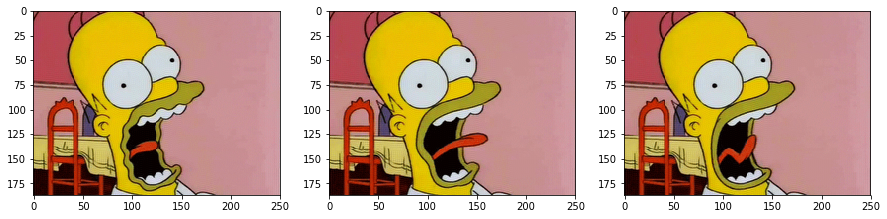

In [4]:
Tiff_show('/Users/zhouhang/Project/Chirp-EE123/asset/simpson/')

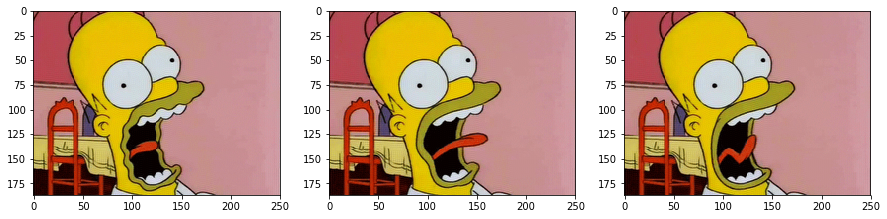

In [5]:
npArray_show(pixData)

In [6]:
# Tiff_play('/Users/zhouhang/Project/Chirp-EE123/asset/Andy_Video/', 1000)
npArray_play(pixData, frame_rate = 20)

In [7]:
def downsample(npArray, factor_xy, timeFlag = False):
    """
    Params:
    timeFlag: whether or not downsample in t index, False by default
    factor_xy: only support float, if wrong type, use 100% by default. 
    
    Notice:
    If you want to use 100%, use 1.0 instead of 1!!
    we only support resample by 2 on time axis!!
    
    """
    if type(factor_xy) is not float:
        print("wrong sampling rate format!!!, continue with factor_xy = 1")
        factor_xy = 1.0
    
    if len(npArray.shape) == 3:
        ori_height= npArray.shape[0]
        ori_width = npArray.shape[1]
        ori_channels = npArray.shape[2]
        timeFlag = False
    else:
        ori_frames = npArray.shape[0]
        ori_height= npArray.shape[1]
        ori_width = npArray.shape[2]
        ori_channels = npArray.shape[3]
        
    
    height = int(ori_height*factor_xy)
    width = int(ori_width*factor_xy)

        
    data_xy = np.empty([ori_frames, height, width, ori_channels], dtype = 'uint8')
    for i in range(ori_frames):
        data_xy[i] = misc.imresize(npArray[i], factor_xy)
    
    
    
    # time axis
    if timeFlag:
        # downsample
        h_t = signal.firwin(ori_frames, 1/2)
        ndimage.convolve1d(data_xy, h_t, axis = 0)

        new_frames = int(np.ceil(ori_frames/2))
        data_t = np.empty([new_frames, height, width, ori_channels], dtype = 'uint8')

        for i in range(frames):
            if i%2 == 0: 
                data_t[i//2] = data_xy[i]
        result = data_t
    else:
        result = data_xy
        
        
    # actually encode the data into bitarray file. 
    origin_info = {
        'height':ori_height,
        'width':ori_width,
        'frames':ori_frames,
        'channels':ori_channels,
        'timeFlag':timeFlag
    }
    
    return result, origin_info

In [8]:
def upsample(npArray, origin_info = None):
    """    
    origin_info: dictionary
    """
    
    frames = npArray.shape[0]
    height= npArray.shape[1]
    width = npArray.shape[2]
    channels = npArray.shape[3]
        
    ori_height = origin_info['height']
    ori_width = origin_info['width']
    ori_channels = origin_info['channels']
    ori_frames = origin_info['frames']
    timeFlag = origin_info['timeFlag']
    
        
        
        
    data_t = np.empty([ori_frames, height, width, ori_channels], dtype = 'uint8')
    # time axis recover first
    if timeFlag:
            # upsample
            for i in range(ori_frames):
                if i%2 == 0:
                    data_t[i] = npArray[i//2]
                else:
                    data_t[i] = np.zeros([height, width, channels], dtype = 'uint8')
            
            # interpolate
#             h_i = np.kaiser(10, 9)
#             idx = np.linspae()
#             ndimage.convolve1d(data_t, h_i, axis = 0)
            data_t = signal.resample(data_t, ori_frames, axis = 0, )
#             data_t = interpolate.interp1d(h, data_t, axis = 0)
            
    else:
        data_t = npArray
                
    # xy axis recover
    result = np.empty([ori_frames, ori_height, ori_width, ori_channels], dtype = 'uint8')
    for i in range(ori_frames):
        result[i] = misc.imresize(data_t[i], [ori_height, ori_width])
    
    return result

In [9]:
r, info= downsample(pixData, 0.5)
print(info)
npArray_play(r, frame_rate = 20)

{'timeFlag': False, 'height': 187, 'channels': 3, 'width': 250, 'frames': 3}


/Users/zhouhang/anaconda3/envs/dsp/lib/python3.5/site-packages/ipykernel/__main__.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [10]:
recon = upsample(r, info)
npArray_play(recon, frame_rate = 20)

/Users/zhouhang/anaconda3/envs/dsp/lib/python3.5/site-packages/ipykernel/__main__.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


## Evaluation

In [12]:
PSNR = psnr(pixData, recon)
print("psnr of comression: %.4f" % PSNR)

psnr of comression: 24.3867
